In [50]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import linalg
from scipy.linalg import hankel
from sklearn.model_selection import KFold
import h5py
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.patches import Patch
from tqdm.notebook import tqdm
from matplotlib import rcParams

In [3]:
#Notebook functions
'''DMD function takes in X and Xprime which are numpy arrays with measurements along the x axis and time along the y 
(i.e each column is a time point with the measurements for that time point down the columns). Each column in X and 
is related to the same column in Xprime as those two columns represent a pair of snapshots of the state of a system 
as it evolves in time. This means X and Xprime are constructed such that for a given column in X, the same column in 
Xprime contains the measurements for the very next time shot of the system. DMD seeks to find the best mapping
possible between these pairs of snapshots that best advances snapshot measurements forward in time. DMD also takes
in a integer value r that stands for rank and indicates how many of the top SVD modes are kept of X for DMD. DMD returns
Phi, Lambda, and b. Lambda is a diagonal matrix of the eigen values of the matrix Atilde produced by DMD on the 
rank reduced X data. Phi is a matrix of the high-dimensional DMD modes which are eigenvectors of the high-dimensional 
A matrix corresponding to the eigenvalues in Lambda. lastly, b contains the DMD mode amplitudes.'''
def DMD(X,Xprime,r):
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    return Phi, Lambda, b

'''Constructs model term library for the model terms of the Lotka-Volterra model.'''
def makeLVM(data):
    n = data.shape[0]#number of time points recorded for each variable x, y of data
    nVars = 2#number of variables in the Lotka-Volterra model
    out = np.zeros((n,1))#initialize matrix to hold function library
    
    # poly order 1, x & y
    for i in range(nVars):
        out = np.append(out,data[:,i].reshape((data.shape[0],1)),axis=1)#append x and y data as first two columns of library
    # poly order 2, xy
    for i in range(nVars):
        for j in range(i + 1,nVars):
            out = np.append(out,(data[:,i]*data[:,j]).reshape((data.shape[0],1)),axis=1)#append xy data as third column
    
    out = out[:,1:]#discard first column of zeros from initialized function library
    return out

'''Function to perform least squares regression with thresholding. The threshold value
below which coefficients are zeroed out is controlled by the input lamb.'''
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

'''
Calculates KL divergence of two distributions. p and p_m are normalized probability distribution.
'''
def kl_divergence(p,p_m):
    return np.sum(p * np.log(p / p_m))


'''
Calculates AIC score for a given model. Takes in array of model predictions and array of true values.
k is an integer value indicating the number of parameters.
'''

def AIC(model,data,k):
    n = len(data)
    RSS = np.linalg.norm(model-data)**2
    sigma2 = RSS / n
    logL = - n* np.log(2*np.pi) / 2 - n * np.log(sigma2) - n / 2
    return 2*k - 2*logL

'''
Calculate BIC score for a given model. Takes in array of model predictions and array of true values.
k is an integer value indicating the number of parameters.
'''
def BIC(model,data,k):
    n = len(data)
    RSS = np.linalg.norm(model-data)**2
    sigma2 = RSS / n
    logL = - n* np.log(2*np.pi) / 2 - n * np.log(sigma2) - n / 2
    return np.log(n) * k - 2 * logL


'''
Constructs model term library for sparse regression. Takes in an array containing the
data for the measured system parameters. Polynomial order and types of sinusoid functions
to include are controllable. Returns array where each column contains values for specifc
model terms at each measured time point.
'''
def poolData(yin,nVars,polyorder,sinusoid=False,sinusoid2=False):
    n = yin.shape[0]
    yout = np.zeros((n,1))
    
    # poly order 0
    yout[:,0] = np.ones(n)
    
    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)
    
    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)       
    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j, nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)
    # poly order 4
    if polyorder >= 4:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j, nVars):
                    for l in range(k, nVars):
                        yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]*yin[:,l]).reshape((yin.shape[0],1)),axis=1)
    
    #sin
    if sinusoid == True:
        #sin(x), sin(y)...
        for i in range(nVars):
            yout = np.append(yout,np.sin(yin[:,i]).reshape((yin.shape[0],1)),axis=1)
        
        #xsin(x), xsin(y), ysin(x)..etc.
        for i in range(nVars):
            for j in range(nVars):
                yout = np.append(yout,(yin[:,i]*np.sin(yin[:,j])).reshape((yin.shape[0],1)),axis=1)
        
        if sinusoid2 == True:    
            #sin(x^2) sin(xy) sin(y^2)
            for i in range(nVars):
                for j in range(i,nVars):
                    yout = np.append(yout,np.sin(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)
    
    return yout
'''Helper function to label bar plots with values'''
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = round(rect.get_height(),2)
        if np.sign(height) == -1:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos]*3, np.sign(height)*12),  # use 3 points offset
                        weight='bold',
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom')
        else:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos]*3, np.sign(height)),  # use 3 points offset
                        weight='bold',
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom')



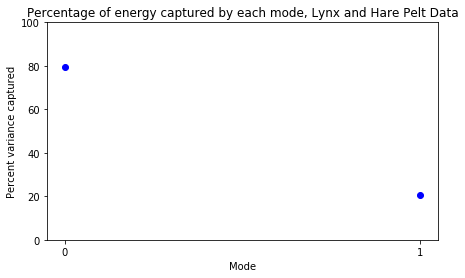

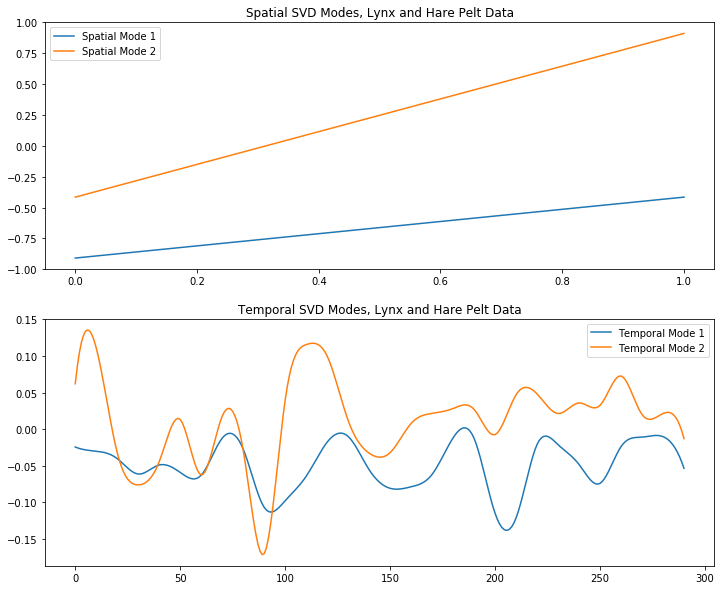

In [103]:
#load in Lynx and Hare pelt data
names = ['Year', 'Hare', 'Lynx']#header names for dataframe
df = pd.read_csv('LynxHareData.txt', header=None ,names=names, delim_whitespace=True)#read in txt file with data
years = df[['Year']].to_numpy()
data = np.transpose(df[['Hare','Lynx']].to_numpy())#for DMD need data at each time point in columns
last_year = df['Year'].iloc[len(df) - 1]
first_year = df['Year'].iloc[0]
dt = (last_year - first_year) / (len(df) - 1)

t = np.arange(0,2*(len(years)),2)#create time array starting from 1 in steps of 2 for 30 iterations
interp = interp1d(t, data, kind='cubic',axis=1)#interpolate to generate more data points

# evaluate interpolation on a finer mesh
scale = 10
t_fine = np.linspace(0,58,30*scale-(scale-1))
dt_interp = t_fine[1] - t_fine[0]
data_interp = interp(t_fine)
m, n = data_interp.shape

X1 = data_interp[:,0:n-2]#all columns starting from first column up to the penultimate
X2 = data_interp[:,1:n-1]#all columns starting from second column up to the last column

#Plot percentage of variance captured by differnt modes
U,Sig,VT = linalg.svd(data_interp, full_matrices=False)
V = np.transpose(VT)
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot((Sig/ sum(Sig)) * 100, 'bo')
ax1.set_title('Percentage of energy captured by each mode, Lynx and Hare Pelt Data')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_ylim(( 0, 100))
ax1.set_xticks([0, 1])

#Plot
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(U[:, 0]), label='Spatial Mode 1')
ax1.plot(np.real(U[:, 1]), label='Spatial Mode 2')
ax1.set_title('Spatial SVD Modes, Lynx and Hare Pelt Data')
ax1.legend()
ax2.plot(np.real(V[:,0]), label='Temporal Mode 1')
ax2.plot(np.real(V[:,1]), label='Temporal Mode 2')
ax2.set_title('Temporal SVD Modes, Lynx and Hare Pelt Data')
ax2.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


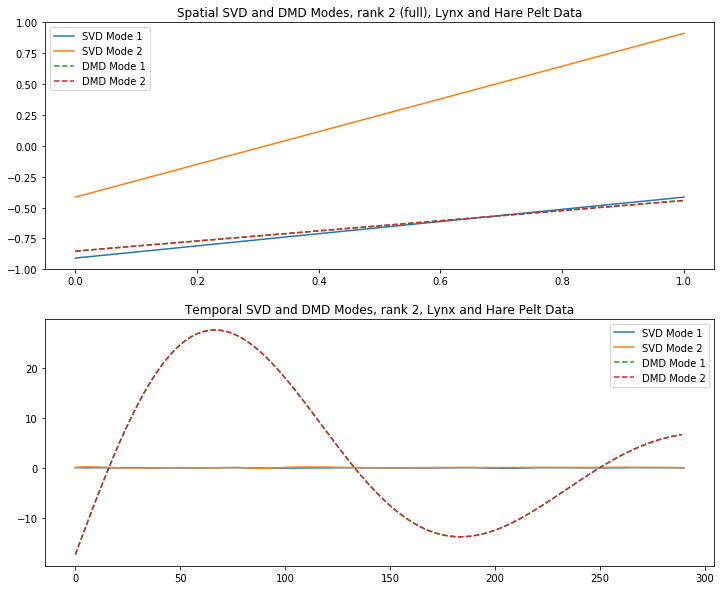

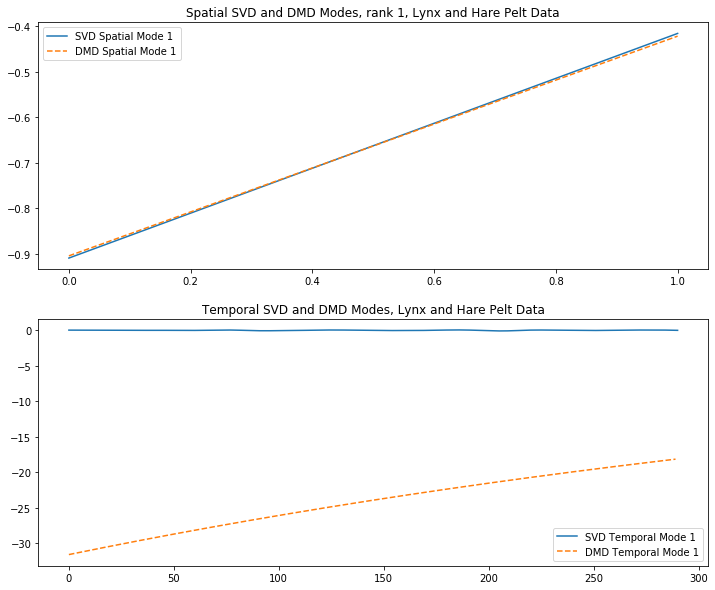

In [104]:
r1 = 1
r2 = 2
Phi_fr, Lambda_fr, b_fr = DMD(X1, X2, r2)#no rank truncation DMD
Phi_r1, Lambda_r1, b_r1 = DMD(X1, X2, r1)#rank 1 truncation DMD

omega_fr = np.log(np.diag(Lambda_fr)) / dt_interp#the continuous eigenvalues full rank DMD
omega_r1 = np.log(np.diag(Lambda_r1)) / dt_interp#the continuous eigenvalues rank 1 DMD


#calculate time dynamics for full rank DMD
time_dynamics_fr = np.empty((r2, len(t_fine) - 1))#intialize time dynamics array
for i in range(0, len(t_fine) - 1):
    time_dynamics_fr[:, i] = b_fr*np.exp(omega_fr*t_fine[i])
X_DMD_fr = np.matmul(Phi_fr, time_dynamics_fr)
#calculate time dynamics for rank 1 DMD
time_dynamics_r1 = np.zeros((r1, len(t_fine) - 1))
for i in range(0, len(t_fine) - 1):
    time_dynamics_r1[:, i] = b_r1*np.exp(omega_r1*t_fine[i])
X_DMD_r1 = np.matmul(Phi_r1, time_dynamics_r1)

#compare the SVD modes to the DMD modes.. DMD says find the modes such that the modes in time are exactly oscillatory
#Plot SVD and DMD modes full rank
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(U[:, 0]), label='SVD Mode 1')
ax1.plot(np.real(U[:, 1]), label='SVD Mode 2')
ax1.plot(np.real(Phi_fr[:, 0]), '--', label='DMD Mode 1')
ax1.plot(np.real(Phi_fr[:, 1]), '--',label='DMD Mode 2')
ax1.set_title('Spatial SVD and DMD Modes, rank 2 (full), Lynx and Hare Pelt Data')
ax1.legend()
ax2.plot(np.real(V[:,0]), label='SVD Mode 1')
ax2.plot(np.real(V[:,1]), label='SVD Mode 2')
ax2.plot(np.real(np.transpose(time_dynamics_fr)[:, 0]), '--', label='DMD Mode 1')
ax2.plot(np.real(np.transpose(time_dynamics_fr)[:, 1]), '--', label='DMD Mode 2')
ax2.set_title('Temporal SVD and DMD Modes, rank 2, Lynx and Hare Pelt Data')
ax2.legend()


#Plot SVD and DMD modes rank 1
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(U[:, 0], label='SVD Spatial Mode 1')
ax1.plot(Phi_r1[:, 0], '--', label='DMD Spatial Mode 1')
ax1.set_title('Spatial SVD and DMD Modes, rank 1, Lynx and Hare Pelt Data')
ax1.legend()
ax2.plot(V[:, 0], label='SVD Temporal Mode 1')
ax2.plot(np.transpose(time_dynamics_r1)[:,0], '--', label='DMD Temporal Mode 1')
ax2.set_title('Temporal SVD and DMD Modes, Lynx and Hare Pelt Data')
ax2.legend()


Text(0, 0.5, 'Hare Pelts (E3)')

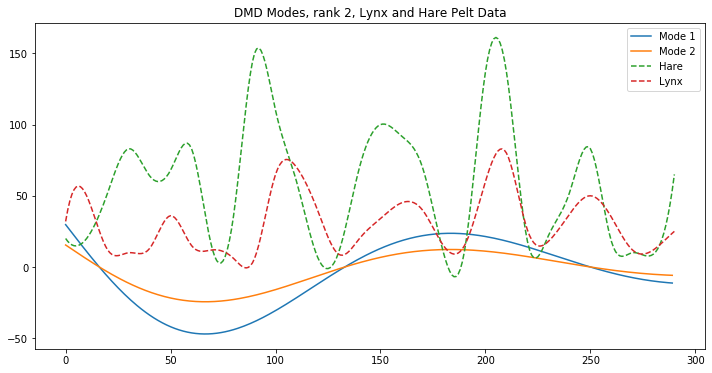

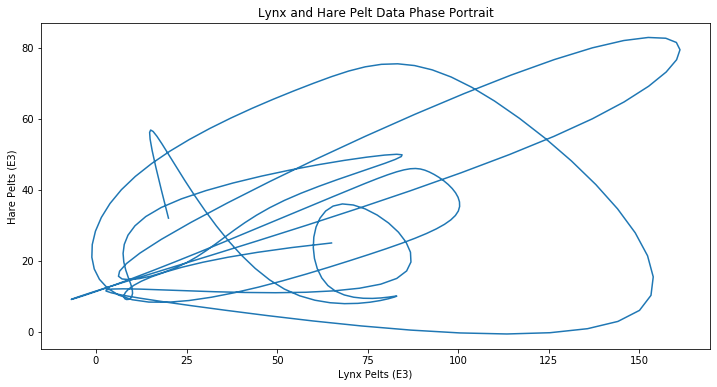

In [105]:
#DMD combined modes for entire data set, prediction is terrible
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.real(X_DMD_fr[0, :]), label='Mode 1')
ax1.plot(np.real(X_DMD_fr[1, :]), label='Mode 2')
ax1.plot(data_interp[0, :], '--', label='Hare')
ax1.plot(data_interp[1, :], '--', label='Lynx')
ax1.set_title('DMD Modes, rank 2, Lynx and Hare Pelt Data')
ax1.legend()

#Phase
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(data_interp[0, :], data_interp[1, :])
ax1.set_title('Lynx and Hare Pelt Data Phase Portrait')
ax1.set_xlabel('Lynx Pelts (E3)')
ax1.set_ylabel('Hare Pelts (E3)')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


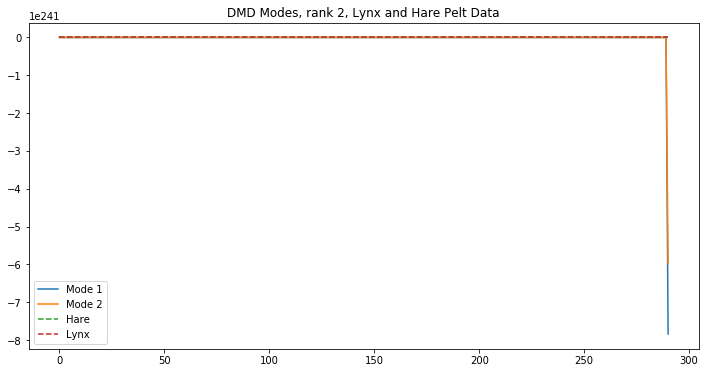

In [106]:
#Try sliding window method, build prediction in chunks
res = 72#how many time points to include per DMD fit
r = 2
X_DMD_total = np.empty((r2, len(t_fine)))
j = 0
start = 0
while (j + res) < len(t_fine) - 1:
    t_chunk = t_fine[j:j+2*res]#make time vector running from chunk start to 2x the time resolution
    X1 = data_interp[:,j:(j + res) - 1]#all columns starting from first column up to the penultimate
    X2 = data_interp[:,(j + 1):(j + res)]#all columns starting from second column up to the last column
    Phi, Lambda, b = DMD(X1, X2, r)#no rank truncation DMD
    omega = np.log(np.diag(Lambda)) / dt_interp#the continuous eigenvalues full rank DMD

    #calculate time dynamics for full rank DMD
    time_dynamics = np.empty((r, len(t_chunk)))#intialize time dynamics array
    for i in range(0, len(t_chunk) - 1):
        time_dynamics[:, i] = b*np.exp(omega*t_chunk[i])
    X_DMD = np.matmul(Phi, time_dynamics)
    X_DMD_total[:, j:(j + 2*res)] = X_DMD
    start = start + res + 1
    j = j + res

#DMD combined modes for entire data set, prediction is terrible
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.real(X_DMD_total[0, :]), label='Mode 1')
ax1.plot(np.real(X_DMD_total[1, :]), label='Mode 2')
ax1.plot(data_interp[0, :], '--', label='Hare')
ax1.plot(data_interp[1, :], '--', label='Lynx')
ax1.set_title('DMD Modes, rank 2, Lynx and Hare Pelt Data')
ax1.legend()

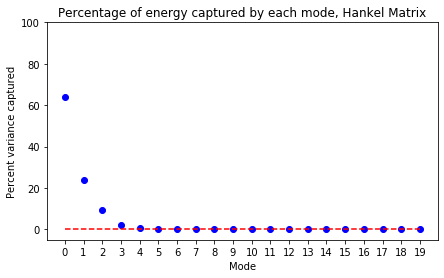

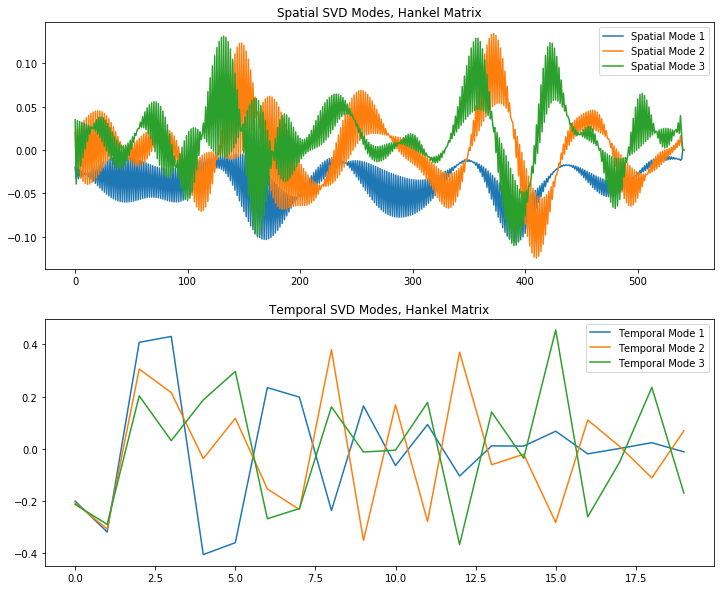

In [107]:
#Make hankel matrices for each variable (Lynx and Hare)
width = 20
rows = len(t_fine) - width#how many sliding windows of specified width can fit within sampled length of time
x1_h = np.empty((rows,width))#initialize Hare hankel
x2_h = np.empty((rows,width))#initialize Lynx hankel
start = 0
j = 0
for i in range(0, rows):
    for j in range(start, (start+width)):
        x1_h[i, (j - i)%width] = data_interp[0,j]
        x2_h[i, (j - i)%width] = data_interp[1,j]
    start = start + 1#reset index to 1 more than the beginning of the window


H = np.empty((2*rows, width))
for i in range(0, rows - 1):
    H[2*i, :] = x1_h[i, :]
    H[2*i + 1, :] = x2_h[i, :]
    

u,s,vh = np.linalg.svd(H)# take SVD

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
xticks = np.arange(len(s)).tolist()
ax1.set_title('Percentage of energy captured by each mode, Hankel Matrix')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_ylim(( -5, 100))
ax1.set_xticks(xticks)
ax1.plot((s/ sum(s)) * 100, 'bo')
ax1.plot(np.arange(len(s)), np.zeros(len(s)), 'r--');

#Plot u (eigen vectors of time delay embedding, dominant correlation structure in space) 
#and v vectors to show the dominant correlated structures in time.
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(u[:, 0]), label='Spatial Mode 1')
ax1.plot(np.real(u[:, 1]), label='Spatial Mode 2')
ax1.plot(np.real(u[:, 2]), label='Spatial Mode 3')
ax1.set_title('Spatial SVD Modes, Hankel Matrix')
ax1.legend()
ax2.plot(np.real(vh[:,0]), label='Temporal Mode 1')
ax2.plot(np.real(vh[:,1]), label='Temporal Mode 2')
ax2.plot(np.real(vh[:,2]), label='Temporal Mode 3')
ax2.set_title('Temporal SVD Modes, Hankel Matrix')
ax2.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


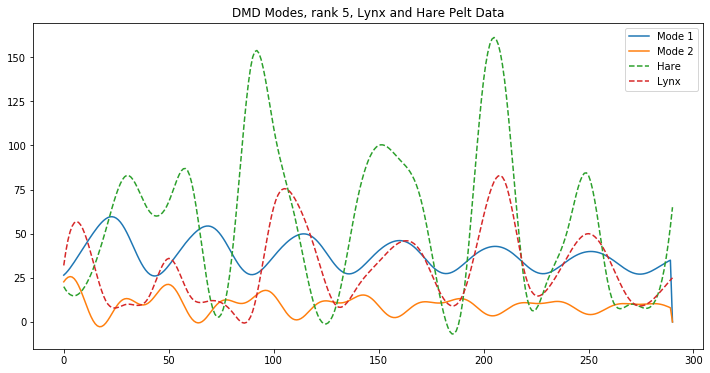

In [108]:
#DMD on Hankel matrix (rank 5)
Phi_H, Lambda_H, b_H = DMD(H[:,0:width - 1], H[:, 1:width], 5)#rank 5 truncation DMD

omega_H = np.log(np.diag(Lambda_H)) / 0.2#the continuous eigenvalues full rank DMD

#calculate time dynamics for full rank DMD
time_dynamics_H = np.empty((5, len(t_fine)))#intialize time dynamics array
for i in range(0, len(t_fine) - 1):
    time_dynamics_H[:, i] = b_H*np.exp(omega_H*t_fine[i])
X_DMD_H = np.matmul(Phi_H, time_dynamics_H)

#DMD combined modes for entire data set, prediction is terrible
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.real(X_DMD_H[0, :]), label='Mode 1')
ax1.plot(np.real(X_DMD_H[1, :]), label='Mode 2')
ax1.plot(data_interp[0, :], '--', label='Hare')
ax1.plot(data_interp[1, :], '--', label='Lynx')
ax1.set_title('DMD Modes, rank 5, Lynx and Hare Pelt Data')
ax1.legend()

In [109]:
'''
Lotka-Volterra model: x ̇ = (b − py)x = bx - pyx and y ̇ = (rx − d)y = rxy - dy
Use the data to fit values of b, p, r and d.
Use sparse regression where the library functions for dx/dt are [x, xy] and y [y, xy]. 
So, the only parameters to get really are just b, p, r, d
'''

dh = np.gradient(data_interp[0], dt_interp)#derivative of hare data (x variable)
dl = np.gradient(data_interp[1], dt_interp)#derivative of lynx data (y variable)
deriv = np.transpose(np.array([dh, dl]))#concatenate derivatives firs col dHare/dt, second col dLynx/dt
A = makeLVM(np.transpose(data_interp))# Make function library for Lotka-Volterra model fit
lamb = 0.025 # sparsification knob lambda
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
Xcv = np.zeros((A.shape[1],2,cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0
for train_index, test_index in kf.split(A):
    Xcv[:,:,cv_i] = sparsifyDynamics(A[train_index,:],deriv[train_index,:],lamb,2)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1
    
Xcv_LVM = np.average(Xcv,axis=2)#average of model coefficients
vals_LVM = A@Xcv_LVM

In [110]:
#kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
A_h = A[:, [0, 2]]
Xcv_h = np.zeros((A_h.shape[1],cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0

for train_index, test_index in kf.split(A_h):
    Xcv_h[:,cv_i] = sparsifyDynamics(A_h[train_index,:],deriv[train_index,0],lamb,0)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1

Xcv_h = np.insert(Xcv_h, 1, 0, axis=0)
Xcv_h_LVM = np.average(Xcv_h,axis=1)#average of model coefficients
vals_h_LVM = A@Xcv_h_LVM

A_l = A[:, [1, 2]]
Xcv_l = np.zeros((A_l.shape[1],cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0

for train_index, test_index in kf.split(A_l):
    Xcv_l[:,cv_i] = sparsifyDynamics(A_l[train_index,:],deriv[train_index,1],lamb,0)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1
Xcv_l = np.insert(Xcv_l, 0, 0, axis=0)
Xcv_l_LVM = np.average(Xcv_l,axis=1)#average of model coefficients
vals_l_LVM = A@Xcv_l_LVM

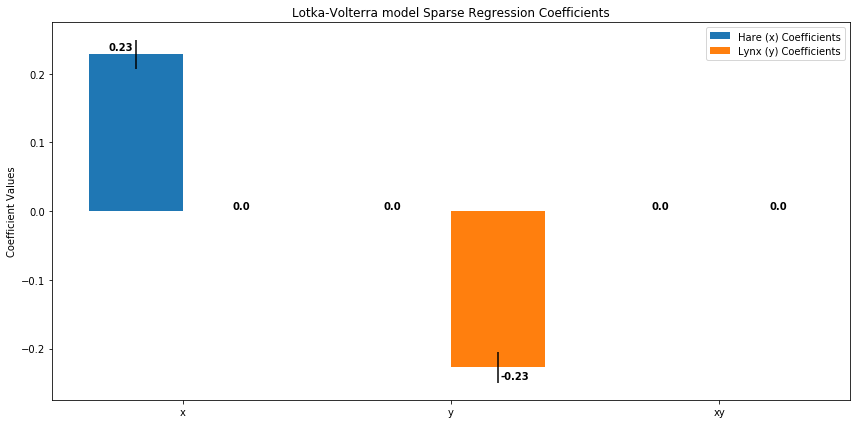

In [111]:
#Plot fit model parameter values
hare_vals = (np.average(Xcv_h[0,:], axis=0), np.average(Xcv_h[1,:], axis=0), np.average(Xcv_h[2,:], axis=0))
lynx_vals = (np.average(Xcv_l[0,:], axis=0), np.average(Xcv_l[1,:], axis=0), np.average(Xcv_l[2,:], axis=0))
hare_std = (np.std(Xcv_h[0,:], axis=0), np.std(Xcv_h[1,:], axis=0), np.std(Xcv_h[2,:], axis=0))
lynx_std = (np.std(Xcv_l[0,:], axis=0), np.std(Xcv_l[1,:], axis=0), np.std(Xcv_l[2,:], axis=0))
ind = np.arange(len(hare_vals))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
rects1 = ax.bar(ind - width/2, hare_vals, width, yerr=hare_std,
                label='Hare (x) Coefficients')
rects2 = ax.bar(ind + width/2, lynx_vals, width, yerr=lynx_std,
                label='Lynx (y) Coefficients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient Values')
ax.set_title('Lotka-Volterra model Sparse Regression Coefficients')
ax.set_xticks(ind)
ax.set_xticklabels(('x', 'y', 'xy'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

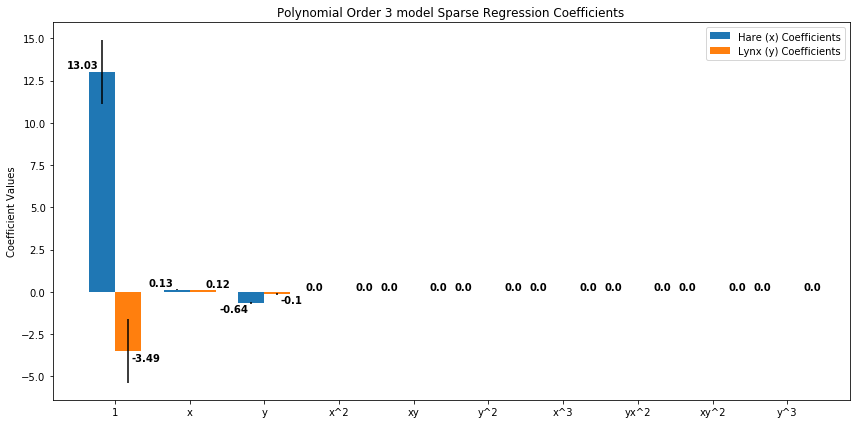

In [112]:
#polynomial non-linear sparse regression model fit
A = poolData(np.transpose(data_interp),2,3)# Make function library for polynomial
lamb = 0.025 # sparsification knob lambda
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
Xcv = np.zeros((A.shape[1],2,cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0
for train_index, test_index in kf.split(A):
    Xcv[:,:,cv_i] = sparsifyDynamics(A[train_index,:],deriv[train_index,:],lamb,2)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1
    
Xcv_poly = np.average(Xcv,axis=2)#average of model coefficients
vals_poly = A@Xcv_poly

#Plot fit model parameter values
hare_vals = []
lynx_vals = []
hare_std = []
lynx_std = []
for i in range(0, Xcv.shape[0]):#for all coefficients
    hare_vals.append(np.average(Xcv[i,0,:], axis=0))
    lynx_vals.append(np.average(Xcv[i,1,:], axis=0))
    hare_std.append(np.std(Xcv[i,0,:], axis=0))
    lynx_std.append(np.std(Xcv[i,0,:], axis=0))

ind = np.arange(len(hare_vals))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
rects1 = ax.bar(ind - width/2, hare_vals, width, yerr=hare_std,
                label='Hare (x) Coefficients')
rects2 = ax.bar(ind + width/2, lynx_vals, width, yerr=lynx_std,
                label='Lynx (y) Coefficients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient Values')
ax.set_title('Polynomial Order 3 model Sparse Regression Coefficients')
ax.set_xticks(ind)
ax.set_xticklabels(('1', 'x', 'y', 'x^2', 'xy', 'y^2', 'x^3', 'yx^2', 'xy^2', 'y^3'))
ax.legend()
autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

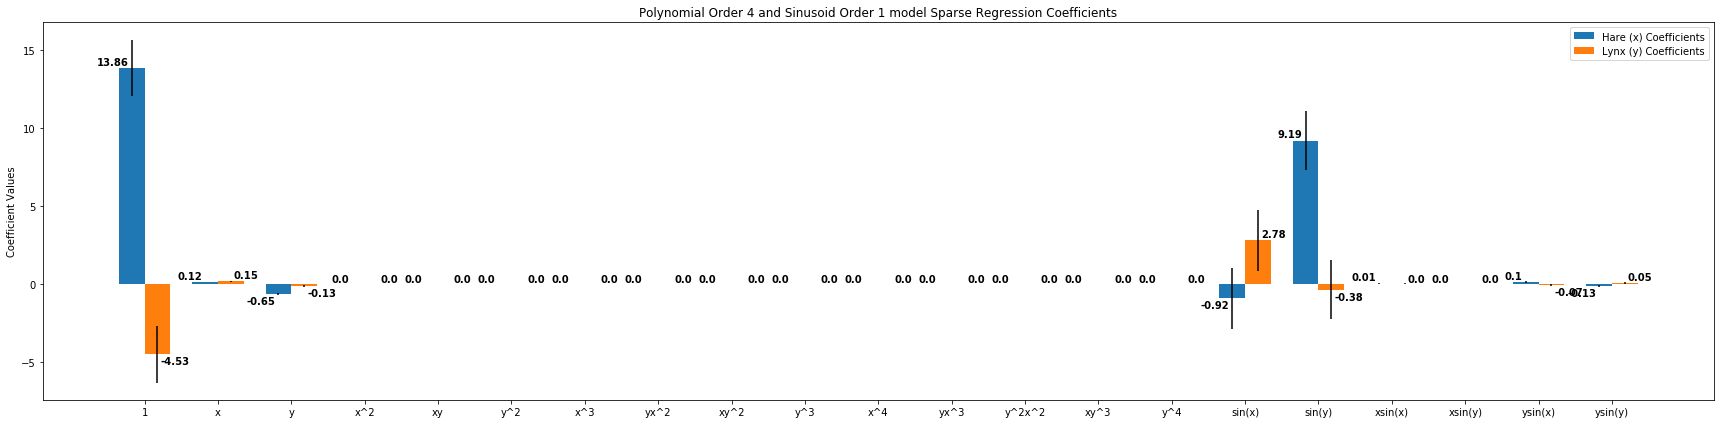

In [113]:
#try sparse regression with sinusoids in pool data library
A = poolData(np.transpose(data_interp),2,4,True)# Make function library for sin 1
lamb = 0.05 # sparsification knob lambda
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
Xcv = np.zeros((A.shape[1],2,cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0
for train_index, test_index in kf.split(A):
    Xcv[:,:,cv_i] = sparsifyDynamics(A[train_index,:],deriv[train_index,:],lamb,2)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1

Xcv_sin1 = np.average(Xcv,axis=2)#average of model coefficients
vals_sin1 = A@Xcv_sin1#apply model

#Plot fit model parameter values
hare_vals = []
lynx_vals = []
hare_std = []
lynx_std = []
for i in range(0, Xcv.shape[0]):#for all coefficients
    hare_vals.append(np.average(Xcv[i,0,:], axis=0))
    lynx_vals.append(np.average(Xcv[i,1,:], axis=0))
    hare_std.append(np.std(Xcv[i,0,:], axis=0))
    lynx_std.append(np.std(Xcv[i,0,:], axis=0))

ind = np.arange(len(hare_vals))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
rects1 = ax.bar(ind - width/2, hare_vals, width, yerr=hare_std,
                label='Hare (x) Coefficients')
rects2 = ax.bar(ind + width/2, lynx_vals, width, yerr=lynx_std,
                label='Lynx (y) Coefficients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient Values')
ax.set_title('Polynomial Order 4 and Sinusoid Order 1 model Sparse Regression Coefficients')
ax.set_xticks(ind)
ax.set_xticklabels(('1', 'x', 'y', 'x^2', 'xy', 'y^2', 'x^3', 'yx^2', 'xy^2', 
                    'y^3', 'x^4', 'yx^3', 'y^2x^2', 'xy^3', 'y^4',
                    'sin(x)', 'sin(y)', 'xsin(x)', 'xsin(y)', 'ysin(x)', 'ysin(y)'))
ax.legend()
autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

#plt.show()

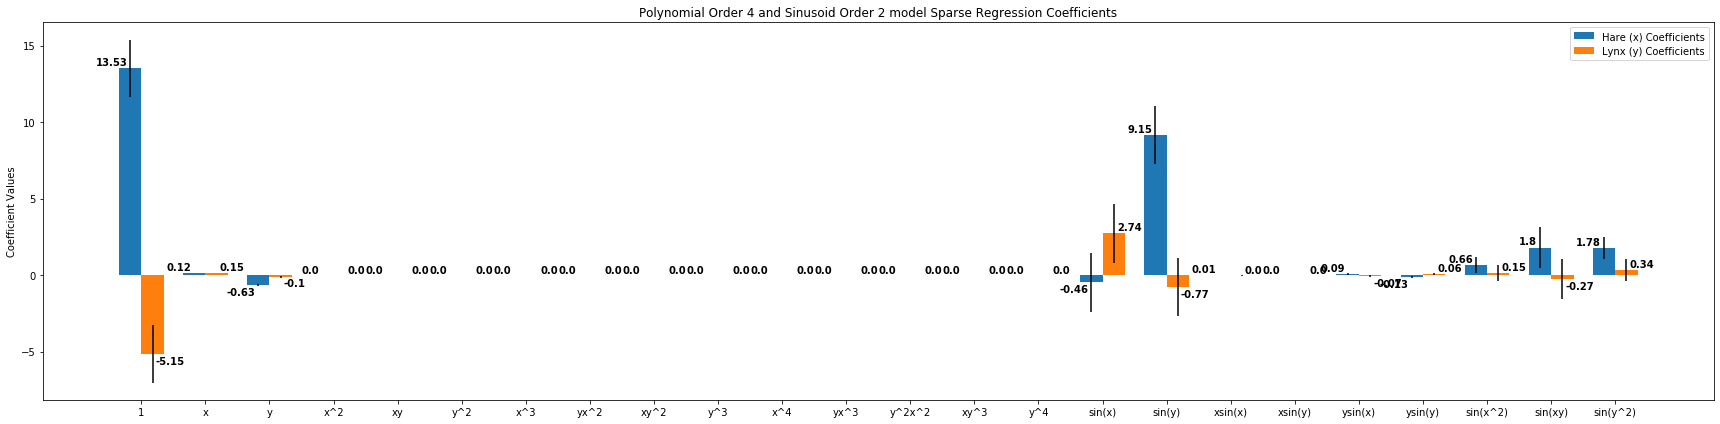

In [114]:
#try with sinusoids of (sin(xy), sin(yx^2), sin(xy^2)) in pool data library
A = poolData(np.transpose(data_interp),2,4,True,True)# Make function library for sin2
lamb = 0.05 # sparsification knob lambda
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
Xcv = np.zeros((A.shape[1],2,cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0
for train_index, test_index in kf.split(A):
    Xcv[:,:,cv_i] = sparsifyDynamics(A[train_index,:],deriv[train_index,:],lamb,2)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1
    
Xcv_sin2 = np.average(Xcv,axis=2)#average of model coefficients
vals_sin2 = A@Xcv_sin2

#Plot fit model parameter values
hare_vals = []
lynx_vals = []
hare_std = []
lynx_std = []
for i in range(0, Xcv.shape[0]):#for all coefficients
    hare_vals.append(np.average(Xcv[i,0,:], axis=0))
    lynx_vals.append(np.average(Xcv[i,1,:], axis=0))
    hare_std.append(np.std(Xcv[i,0,:], axis=0))
    lynx_std.append(np.std(Xcv[i,0,:], axis=0))

ind = np.arange(len(hare_vals))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
rects1 = ax.bar(ind - width/2, hare_vals, width, yerr=hare_std,
                label='Hare (x) Coefficients')
rects2 = ax.bar(ind + width/2, lynx_vals, width, yerr=lynx_std,
                label='Lynx (y) Coefficients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient Values')
ax.set_title('Polynomial Order 4 and Sinusoid Order 2 model Sparse Regression Coefficients')
ax.set_xticks(ind)
ax.set_xticklabels(('1', 'x', 'y', 'x^2', 'xy', 'y^2', 'x^3', 'yx^2', 'xy^2', 
                    'y^3', 'x^4', 'yx^3', 'y^2x^2', 'xy^3', 'y^4','sin(x)', 'sin(y)', 
                    'xsin(x)', 'xsin(y)', 'ysin(x)', 'ysin(y)',
                   'sin(x^2)','sin(xy)', 'sin(y^2)'))
ax.legend()
autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

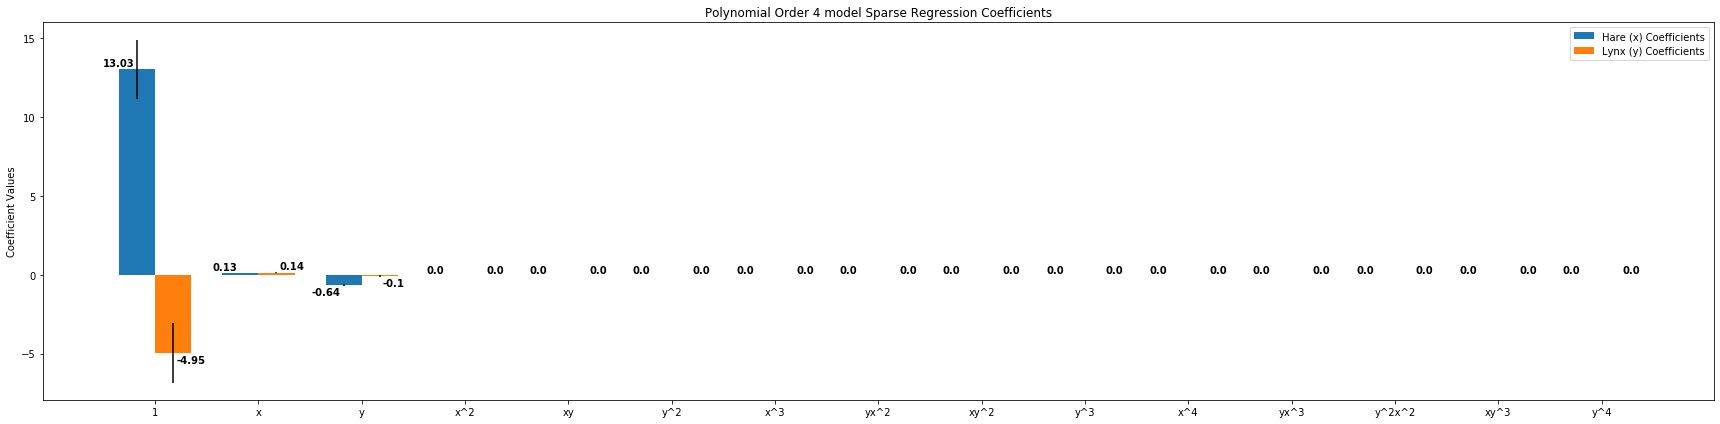

In [115]:
#try 4th degree polynomial
A = poolData(np.transpose(data_interp),2,4)# Make function library for sin2
lamb = 0.05 # sparsification knob lambda
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
Xcv = np.zeros((A.shape[1],2,cv_folds))#for storing cross validation of least squares thresholding coeffs 3 coeffs (x, y, xy)x 2 variables (x, y) x k folds
cv_i = 0
for train_index, test_index in kf.split(A):
    Xcv[:,:,cv_i] = sparsifyDynamics(A[train_index,:],deriv[train_index,:],lamb,2)#least squares thresholding to fit model library to derivative
    cv_i = cv_i + 1
    
Xcv_p4 = np.average(Xcv,axis=2)#average of model coefficients
vals_p4 = A@Xcv_p4

#Plot fit model parameter values
hare_vals = []
lynx_vals = []
hare_std = []
lynx_std = []
for i in range(0, Xcv.shape[0]):#for all coefficients
    hare_vals.append(np.average(Xcv[i,0,:], axis=0))
    lynx_vals.append(np.average(Xcv[i,1,:], axis=0))
    hare_std.append(np.std(Xcv[i,0,:], axis=0))
    lynx_std.append(np.std(Xcv[i,0,:], axis=0))

ind = np.arange(len(hare_vals))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(24, 6))
rects1 = ax.bar(ind - width/2, hare_vals, width, yerr=hare_std,
                label='Hare (x) Coefficients')
rects2 = ax.bar(ind + width/2, lynx_vals, width, yerr=lynx_std,
                label='Lynx (y) Coefficients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient Values')
ax.set_title('Polynomial Order 4 model Sparse Regression Coefficients')
ax.set_xticks(ind)
ax.set_xticklabels(('1', 'x', 'y', 'x^2', 'xy', 'y^2', 'x^3', 'yx^2', 'xy^2', 
                    'y^3', 'x^4', 'yx^3', 'y^2x^2', 'xy^3', 'y^4'))
ax.legend()
autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

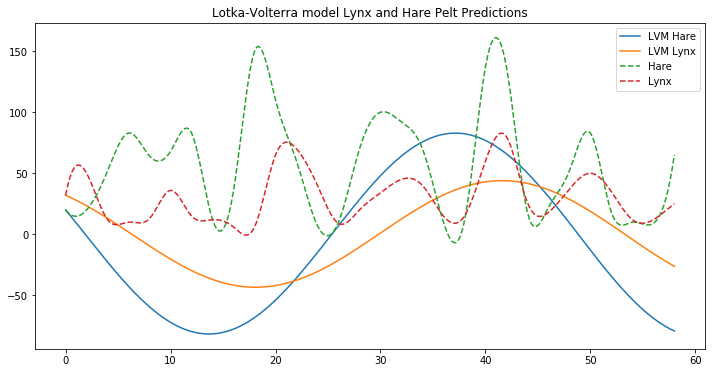

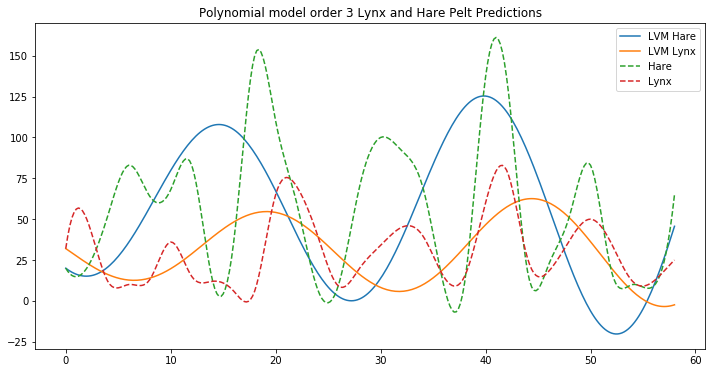

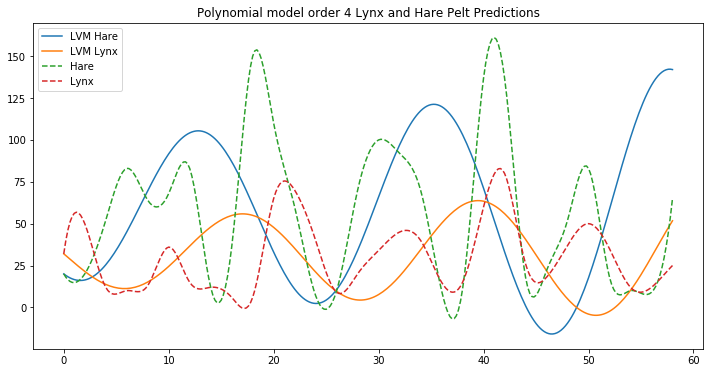

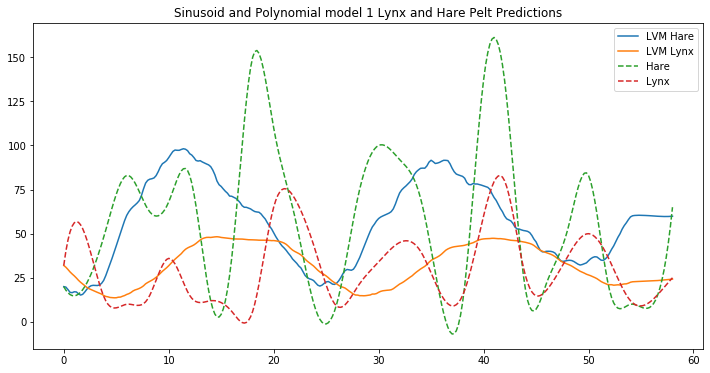

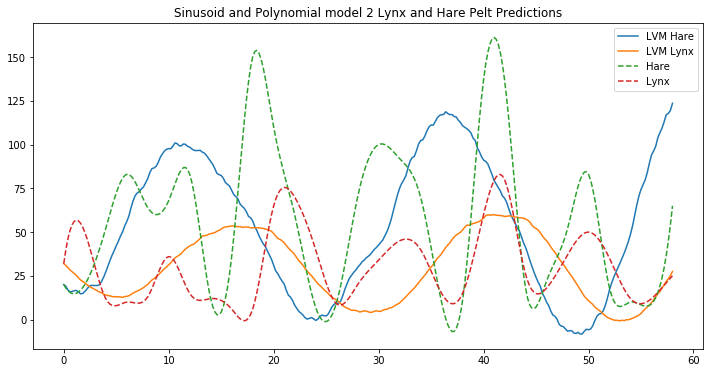

In [116]:
'''Compute AIC, BIC, KL Divergence for DMD, Time delay DMD, Lotka-Volterra model, Non-linear poly order 3, 
Non-linear poly order 3 with simple sinusoids, and Non-linear poly order 3 with sinusoids'''
from scipy import integrate

'''y is 2D array with each column corresponding to a variable, rows the time points'''
def rhs_LVM(t, y):
    coeffs = Xcv_LVM
    var1 = np.where(abs(coeffs[:,0])>0)
    var2 = np.where(abs(coeffs[:,1])>0)
    A = np.transpose(makeLVM(y.reshape(1, -1))).flatten()# Make function library for Lotka-Volterra model fit
    return np.array([sum(A[var1]*np.transpose(coeffs[var1, 0]).flatten()), sum(A[var2]*np.transpose(coeffs[var2, 1]).flatten())])
def rhs_poly(t, y):
    coeffs = Xcv_poly
    var1 = np.where(abs(coeffs[:,0])>0)
    var2 = np.where(abs(coeffs[:,1])>0)
    A = np.transpose(poolData(y.reshape(1, -1),2,3)).flatten()# Make function library for polynomial
    return np.array([sum(A[var1]*np.transpose(coeffs[var1, 0]).flatten()), sum(A[var2]*np.transpose(coeffs[var2, 1]).flatten())])
def rhs_sin1(t, y):
    coeffs = Xcv_sin1
    var1 = np.where(abs(coeffs[:,0])>0)
    var2 = np.where(abs(coeffs[:,1])>0)
    A = np.transpose(poolData(y.reshape(1, -1),2,4,True)).flatten()# Make function library for sin 1
    return np.array([sum(A[var1]*np.transpose(coeffs[var1, 0]).flatten()), sum(A[var2]*np.transpose(coeffs[var2, 1]).flatten())])
def rhs_sin2(t, y):
    coeffs = Xcv_sin2
    var1 = np.where(abs(coeffs[:,0])>0)
    var2 = np.where(abs(coeffs[:,1])>0)
    A = np.transpose(poolData(y.reshape(1, -1),2,4,True,True)).flatten()# Make function library for sin2
    return np.array([sum(A[var1]*np.transpose(coeffs[var1, 0]).flatten()), sum(A[var2]*np.transpose(coeffs[var2, 1]).flatten())])
def rhs_p4(t, y):
    coeffs = Xcv_p4
    var1 = np.where(abs(coeffs[:,0])>0)
    var2 = np.where(abs(coeffs[:,1])>0)
    A = np.transpose(poolData(y.reshape(1, -1),2,4,True,True)).flatten()# Make function library for sin2
    return np.array([sum(A[var1]*np.transpose(coeffs[var1, 0]).flatten()), sum(A[var2]*np.transpose(coeffs[var2, 1]).flatten())])

y0 = data_interp[:,0]#initial values for hare and lynx populations
model0 = integrate.solve_ivp(rhs_LVM,[0,58],y0,method='RK45',t_eval=t_fine)
model1 = integrate.solve_ivp(rhs_poly,[0,58],y0,method='RK45',t_eval=t_fine)
model2 = integrate.solve_ivp(rhs_sin1,[0,58],y0,method='RK45',t_eval=t_fine)
model3 = integrate.solve_ivp(rhs_sin2,[0,58],y0,method='RK45',t_eval=t_fine)
model4 = integrate.solve_ivp(rhs_p4,[0,58],y0,method='RK45',t_eval=t_fine)

#plot the integrated values of Lotka-Volterra model
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.linspace(0,58,len(model0.y[0,:])), model0.y[0,:], label='LVM Hare')
ax1.plot(np.linspace(0,58,len(model0.y[0,:])), model0.y[1,:], label='LVM Lynx')
ax1.plot(t_fine, data_interp[0, :], '--', label='Hare')
ax1.plot(t_fine, data_interp[1, :], '--', label='Lynx')
ax1.set_title('Lotka-Volterra model Lynx and Hare Pelt Predictions')
ax1.legend()
#plot the integrated values of polynomial library fit
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.linspace(0,58,len(model1.y[0,:])), model1.y[0,:], label='LVM Hare')
ax1.plot(np.linspace(0,58,len(model1.y[0,:])), model1.y[1,:], label='LVM Lynx')
ax1.plot(t_fine, data_interp[0, :], '--', label='Hare')
ax1.plot(t_fine, data_interp[1, :], '--', label='Lynx')
ax1.set_title('Polynomial model order 3 Lynx and Hare Pelt Predictions')
ax1.legend()
#plot the integrated values of polynomial order 4 library fit
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.linspace(0,58,len(model4.y[0,:])), model4.y[0,:], label='LVM Hare')
ax1.plot(np.linspace(0,58,len(model4.y[0,:])), model4.y[1,:], label='LVM Lynx')
ax1.plot(t_fine, data_interp[0, :], '--', label='Hare')
ax1.plot(t_fine, data_interp[1, :], '--', label='Lynx')
ax1.set_title('Polynomial model order 4 Lynx and Hare Pelt Predictions')
ax1.legend()
#plot the integrated values of sinusoid library fit 1
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.linspace(0,58,len(model2.y[0,:])), model2.y[0,:], label='LVM Hare')
ax1.plot(np.linspace(0,58,len(model2.y[0,:])), model2.y[1,:], label='LVM Lynx')
ax1.plot(t_fine, data_interp[0, :], '--', label='Hare')
ax1.plot(t_fine, data_interp[1, :], '--', label='Lynx')
ax1.set_title('Sinusoid and Polynomial model 1 Lynx and Hare Pelt Predictions')
ax1.legend()
#plot the integrated values of sinusoid library fit 2
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.linspace(0,58,len(model3.y[0,:])), model3.y[0,:], label='LVM Hare')
ax1.plot(np.linspace(0,58,len(model3.y[0,:])), model3.y[1,:], label='LVM Lynx')
ax1.plot(t_fine, data_interp[0, :], '--', label='Hare')
ax1.plot(t_fine, data_interp[1, :], '--', label='Lynx')
ax1.set_title('Sinusoid and Polynomial model 2 Lynx and Hare Pelt Predictions')
ax1.legend()

In [117]:
#AIC BIC KL Div
all_models = [X_DMD_fr, X_DMD_total, X_DMD_H[0:2, :],model0.y
              , model1.y, model4.y, model2.y, model3.y]
models = ['DMD', 'Sliding DMD', 'Time Delay DMD', 'Lotka-Volterra', 'Polynomial Order 3', 
          'Polynomial Order 4', 'Polynomial Order 4 + Sinusoids Polynomial Order 1',
         'Polynomial Order 4 + Sinusoids Polynomial Order 2']
aic = np.zeros(len(models))
bic = np.zeros(len(models))
kl_div = np.zeros(len(models))
k = 2
for i in range(0, len(models)):
    if models[i] == 'DMD':
        data = data_interp[:,:290]
    else:
        data = data_interp
    model = all_models[i]
    aic[i] = AIC(model,data,k)
    bic[i] = BIC(model,data,k)
    
    #For KL Divergence 1)histogram of data w/ each bin = a population count and
    #height of bin = number of data points in interpolated time series that has 
    #that population count. 2)Normalize histogram to get probability distribution
    center= np.average(data,axis=1)
    pd_data = np.histogram2d(data[0],data[1],[[-np.inf,center[0],np.inf],[-np.inf,center[1],np.inf]])[0]
    pd_model = np.histogram2d(model[0],model[1],[[-np.inf,center[0],np.inf],[-np.inf,center[1],np.inf]])[0]
    #Normalize probability distributions
    pd_data /= np.sum(pd_data)
    pd_model /= np.sum(pd_model)
    # compute KL divergence
    kl_div[i] = kl_divergence(pd_data, pd_model)

df = pd.DataFrame({"Model": models, "AIC": aic, "BIC": bic, "KL-Divergence": kl_div})
display(df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


,Model,AIC,BIC,KL-Divergence
0,DMD,65.438210,62.824505,inf
1,Sliding DMD,inf,inf,inf
2,Time Delay DMD,61.542170,58.928465,inf
3,Lotka-Volterra,66.528297,63.914592,0.269209
4,Polynomial Order 3,61.724015,59.110309,0.013239
5,Polynomial Order 4,63.220951,60.607246,0.000272
6,Polynomial Order 4 + Sinusoids Polynomial Order 1,60.553052,57.939346,0.016766
7,Polynomial Order 4 + Sinusoids Polynomial Order 2,62.283924,59.670219,0.002573


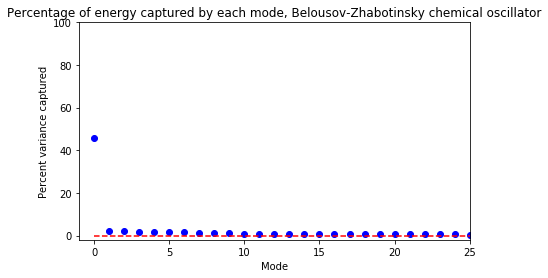

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


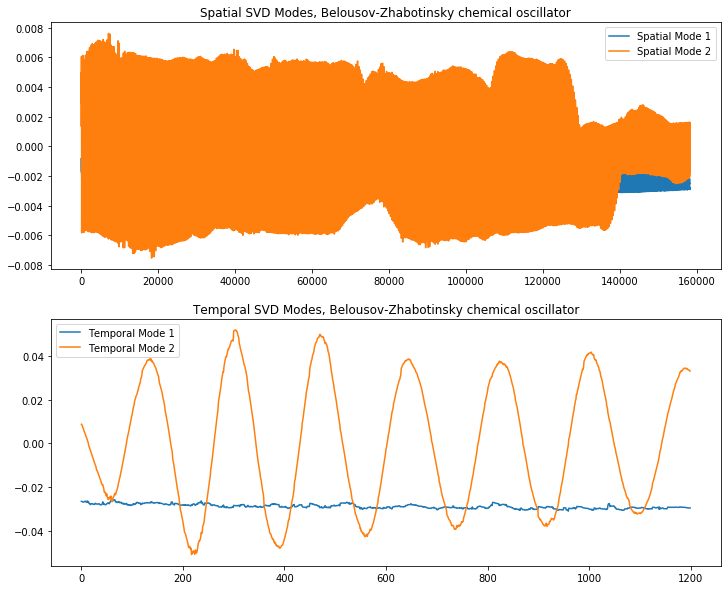

In [4]:
'''
Download the data set BZ.mat (which is a snipet from a Belousov-Zhabotinsky chemical oscillator movie – check them out on youtube).
1. get the data: download from the course website (It is next to HW 2)
2. See what you can do with the data (i.e. repeat the first two steps above)
'''
file = h5py.File('BZ.mat','r')
data = np.array(file.get('BZ_tensor'))
[r,c,d] = data.shape
dt = 0.2#guess of movie dt
t = np.arange(0, r*0.2, 0.2)#time range of movie
data_flat = np.transpose(data.reshape(data.shape[0], -1))#each column is a time point

# train the normalization
scaler = MinMaxScaler()
scaler = scaler.fit(data_flat)
#print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
data_flat = scaler.transform(data_flat)

n = data_flat.shape[1]
X1 = data_flat[:,0:n-2]#all columns starting from first column up to the penultimate
X2 = data_flat[:,1:n-1]#all columns starting from second column up to the last column

#Plot percentage of variance captured by differnt modes
U,Sig,VT = linalg.svd(data_flat, full_matrices=False)
V = np.transpose(VT)
f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot((Sig/ sum(Sig)) * 100, 'bo')
ax1.plot(np.zeros((len(Sig))), 'r--')
ax1.set_title('Percentage of energy captured by each mode, Belousov-Zhabotinsky chemical oscillator')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_ylim(( -2, 100))
ax1.set_xlim(( -1, 25))


#Plot
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(U[:, 0]), label='Spatial Mode 1')
ax1.plot(np.real(U[:, 1]), label='Spatial Mode 2')
ax1.set_title('Spatial SVD Modes, Belousov-Zhabotinsky chemical oscillator')
ax1.legend()
ax2.plot(np.real(V[:,0]), label='Temporal Mode 1')
ax2.plot(np.real(V[:,1]), label='Temporal Mode 2')
ax2.set_title('Temporal SVD Modes, Belousov-Zhabotinsky chemical oscillator')
ax2.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


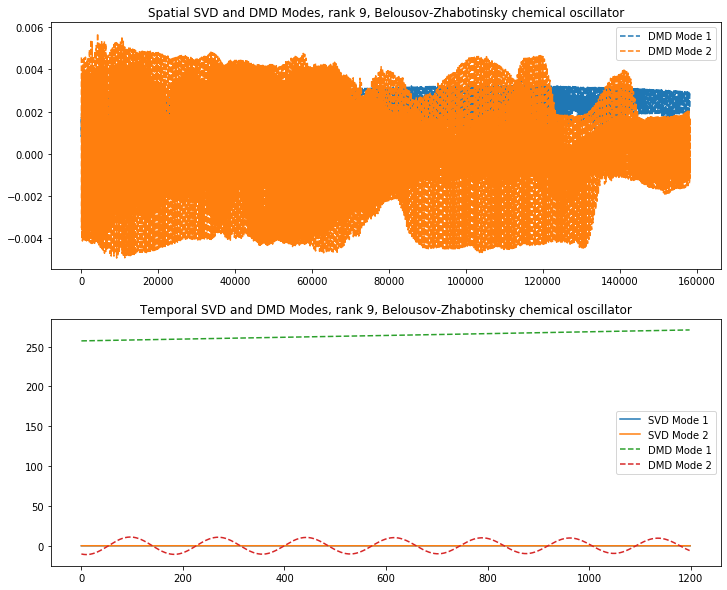

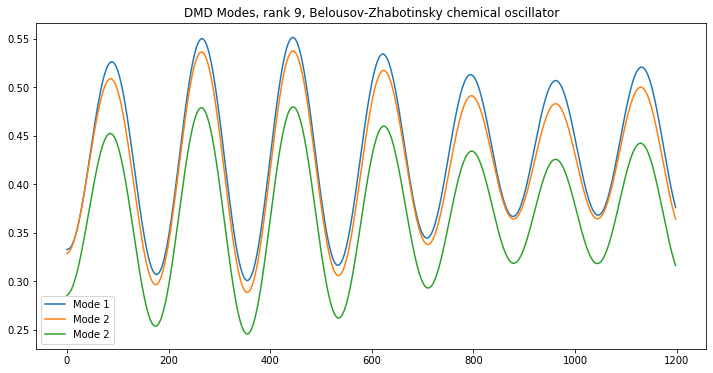

In [5]:
rank = 5#rank 9 truncation
Phi, Lambda, b = DMD(X1, X2, rank)#no rank truncation DMD

omega = np.log(np.diag(Lambda)) / dt#the continuous eigenvalues full rank DMD

#calculate time dynamics for full rank DMD
time_dynamics = np.empty((rank, r - 1))#intialize time dynamics array
for i in range(0, r - 1):
    time_dynamics[:, i] = b*np.exp(omega*t[i])
X_DMD_BZ = np.matmul(Phi, time_dynamics)


#compare the SVD modes to the DMD modes.. DMD says find the modes such that the modes in time are exactly oscillatory
#Plot SVD and DMD modes full rank
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(Phi[:, 0]), '--', label='DMD Mode 1')
ax1.plot(np.real(Phi[:, 1]), '--',label='DMD Mode 2')
ax1.set_title('Spatial SVD and DMD Modes, rank 9, Belousov-Zhabotinsky chemical oscillator')
ax1.legend()
ax2.plot(np.real(V[:,0]), label='SVD Mode 1')
ax2.plot(np.real(V[:,1]), label='SVD Mode 2')
ax2.plot(np.real(np.transpose(time_dynamics)[:, 0]), '--', label='DMD Mode 1')
ax2.plot(np.real(np.transpose(time_dynamics)[:, 1]), '--', label='DMD Mode 2')
ax2.set_title('Temporal SVD and DMD Modes, rank 9, Belousov-Zhabotinsky chemical oscillator')
ax2.legend()

#DMD combined modes for entire data set, prediction is terrible
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.real(X_DMD_BZ[0, :]), label='Mode 1')
ax1.plot(np.real(X_DMD_BZ[1, :]), label='Mode 2')
ax1.plot(np.real(X_DMD_BZ[2, :]), label='Mode 2')
ax1.set_title('DMD Modes, rank 9, Belousov-Zhabotinsky chemical oscillator')
ax1.legend()

In [41]:
#get low rank approximation of data matrix
r = 20
Ar = np.zeros((r, 1200))
for i in range(r):
    Ar[i,:] = Sig[i] * U[i]* VT[i]

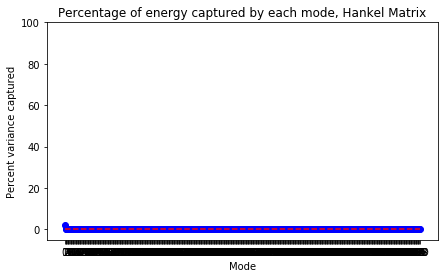

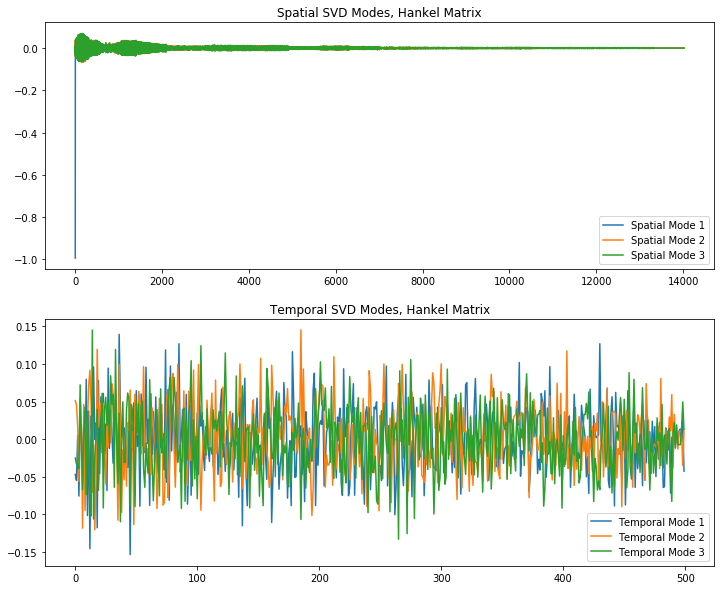

In [43]:
#Make hankel matrices for each variable
width = 500
rows = len(t) - width + 1#how many sliding windows of specified width can fit within sampled length of time
H = np.empty((r*rows, width))
start = 0
j = 0
i = 1
while i < (rows + 1):
    print("Progress {:2.1%}".format(i / (rows+1)), end="\r")#print progress
    for k in range(0, Ar.shape[0]):
        for j in range(start, (start+width)):
            H[i*k, (j - i)%width] = Ar[k,j]
        
    start = start + 1#reset index to 1 more than the beginning of the window
    i = i + 1#reset Hankel matrix row index holder to next set of time delay arrays

u,s,vh = np.linalg.svd(H)# take SVD

f, ax1 = plt.subplots(1, 1, figsize=(7, 4))
xticks = np.arange(len(s)).tolist()
ax1.set_title('Percentage of energy captured by each mode, Hankel Matrix')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_ylim(( -5, 100))
ax1.set_xticks(xticks)
ax1.plot((s/ sum(s)) * 100, 'bo')
ax1.plot(np.arange(len(s)), np.zeros(len(s)), 'r--');

#Plot u (eigen vectors of time delay embedding, dominant correlation structure in space) 
#and v vectors to show the dominant correlated structures in time.
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(np.real(u[:, 0]), label='Spatial Mode 1')
ax1.plot(np.real(u[:, 1]), label='Spatial Mode 2')
ax1.plot(np.real(u[:, 2]), label='Spatial Mode 3')
ax1.set_title('Spatial SVD Modes, Hankel Matrix')
ax1.legend()
ax2.plot(np.real(vh[:,0]), label='Temporal Mode 1')
ax2.plot(np.real(vh[:,1]), label='Temporal Mode 2')
ax2.plot(np.real(vh[:,2]), label='Temporal Mode 3')
ax2.set_title('Temporal SVD Modes, Hankel Matrix')
ax2.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


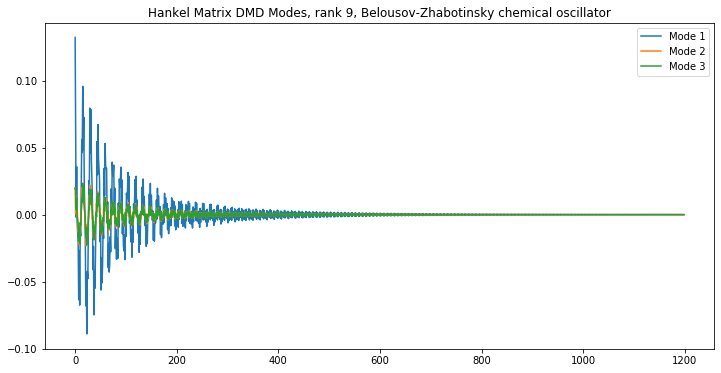

In [49]:
#DMD on Hankel matrix (rank 4)
r = 9
Phi_BZ_H, Lambda_BZ_H, b_BZ_H = DMD(H[:,0:width - 1], H[:, 1:width], r)#rank 4 truncation DMD

omega_BZ_H = np.log(np.diag(Lambda_BZ_H)) / dt#the continuous eigenvalues full rank DMD

#calculate time dynamics for full rank DMD
time_dynamics_BZ_H = np.empty((r, len(t)))#intialize time dynamics array
for i in range(0, len(t) - 1):
    time_dynamics_BZ_H[:, i] = b_BZ_H*np.exp(omega_BZ_H*t[i])
X_DMD_BZ_H = np.matmul(Phi_BZ_H, time_dynamics_BZ_H)

#Hankel Matrix DMD modes
f, ax1 = plt.subplots(1, 1, figsize=(12, 6))
ax1.plot(np.real(X_DMD_BZ_H[0, :1199]), label='Mode 1')
ax1.plot(np.real(X_DMD_BZ_H[1, :1199]), label='Mode 2')
ax1.plot(np.real(X_DMD_BZ_H[2, :1199]), label='Mode 3')
ax1.set_title('Hankel Matrix DMD Modes, rank 9, Belousov-Zhabotinsky chemical oscillator')
ax1.legend()